# Pairs Trading of VISA (V) and MasterCard (MA)

### 1. Example of Loading the Sample Data for Reference and Reproduction

In [1]:
# importing the necessary libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance          as yf

# Downloading data for assets under consideration for example
symbols = ['V', 'MA']
price_data = yf.download(symbols, start='2013-01-01', end='2023-01-01')

# converting the data fetched to csv so that it can be viewed as an example
price_data.to_csv("yfinance_Sample_Downloaded_Data_V_and_MA.csv")

[*********************100%***********************]  2 of 2 completed


In [2]:
print("Numpy: %s ",np.__version__)
print("Pandas: %s ",pd.__version__)

Numpy: %s  1.22.4
Pandas: %s  1.4.4


### 2. Pairs Trading Using strategy of buying the loser

In [3]:
####################################################
#  INITIAL TESTING OF STRATEGY OF BUYING THE LOSER #
####################################################

# importing necessary libraries
import yfinance as yf
import pandas as pd

# Pulling historical data for V and MA from yfinance
tickers = ['V', 'MA']
start_date = '2013-01-01'
end_date = '2023-01-01'
data = yf.download(tickers, start=start_date, end=end_date)

# Calculating rolling correlation between the two tickers
rolling_corr = data['Close']['V'].rolling(window=30).corr(data['Close']['MA'])

# Calculating the ratio of V and MA prices
ratio = data['Close']['V'] / data['Close']['MA']

# Temporary buying the loser
buy_v = (rolling_corr < 0.5) & (ratio > ratio.mean())
buy_ma = (rolling_corr < 0.5) & (ratio < ratio.mean())

# Calculating profit and loss
pnl = pd.DataFrame(index=data.index)
pnl['V'] = buy_v.shift(1) * (data['Close']['V'] - data['Open']['V'])
pnl['MA'] = buy_ma.shift(1) * (data['Close']['MA'] - data['Open']['MA'])
pnl['Total'] = pnl['V'] + pnl['MA']

# Calculating total profit and loss over the period
total_pnl = pnl.sum()

# Printing the total profit and loss
print("Total PNL for V and MA: \n", total_pnl)

# We can see it doesn't look that good of a strategy in the first pass
# But, let's try to build this rigorously and test it against baseline buy and hold strategy

[*********************100%***********************]  2 of 2 completed
Total PNL for V and MA: 
 V       -15.414963
MA      -34.151947
Total    -49.56691
dtype: object


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


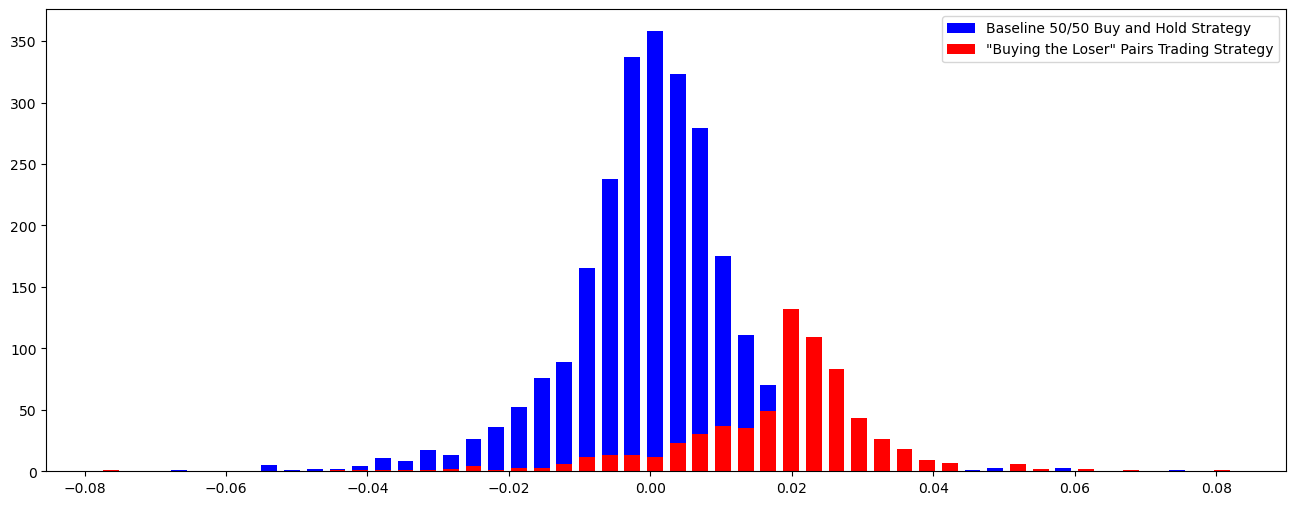

######### Summary: Returns using "Buying the Loser" Pairs Trading Strategy #########
Mean return = 0.04 %
Standard deviaton of the return = 1.48 %
Minimum return = -9.89 %
Maximum return = 6.65 %
Lower quantile of return = -0.5 %
Median return of return = 0.27 %
Upper quantile of return = 0.8 %
####################################################################################


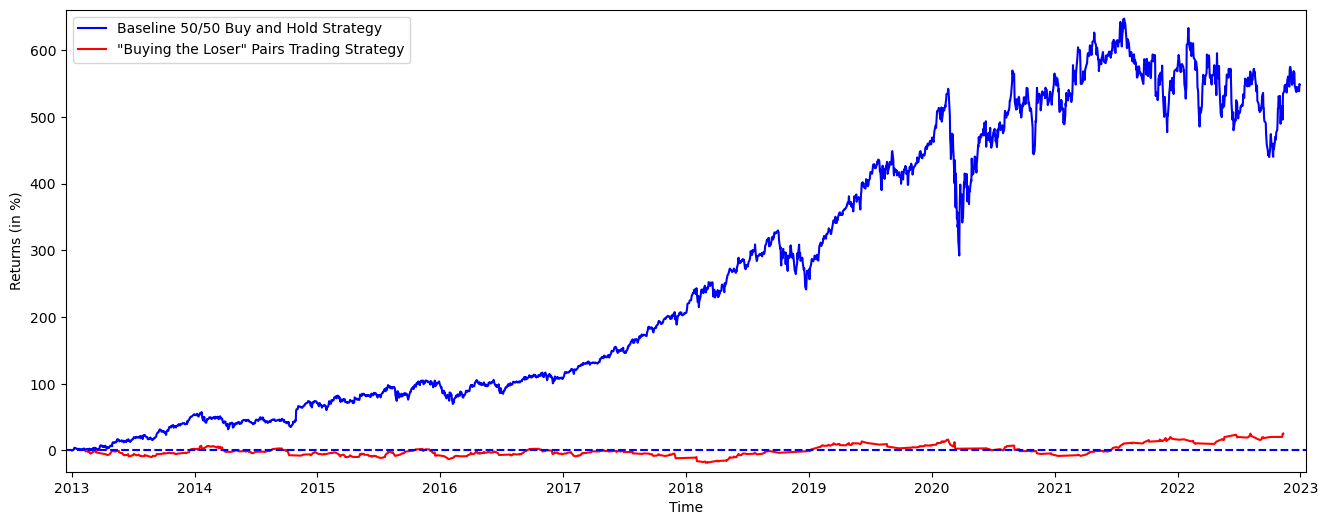

In [4]:
####################################################
#  RIGOROUS TESTING OF STRATEGY OF BUYING THE LOSER #
####################################################

# importing the necessary libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance          as yf

# Downloading data for V and MA
start_date, end_date = '2013-01-01', '2023-01-01'
V = yf.download("V", start=start_date, end=end_date)
MA = yf.download("MA", start=start_date, end=end_date)

######### W/O Transactional Cost ##########
pairs = pd.DataFrame({'TV':V['Close'].shift(1)/V['Close'].shift(2)-1,
                      'TMA':MA['Close'].shift(1)/MA['Close'].shift(2)-1})

# we will buy the asset which was loser yesterday (buying the loser), so we find the loser
pairs['Target'] = pairs.min(axis=1)

# Generating the signal based on the correlation
pairs['Correlation'] = ((V['Close'].shift(1)/V['Close'].shift(20)-1).rolling(window=9)
                        .corr((MA['Close'].shift(1)/MA['Close'].shift(20)-1)))

Signal = pairs['Correlation'] < 0.9

# We're holding positions that weren't profitable yesterday
HoldingYesterdayPosition = ((pairs['Target'].shift(1).isin(pairs['TV']) &
                             (V['Close'].shift(1)/V['Open'].shift(1)-1 < 0)) |
                            (pairs['Target'].shift(1).isin(pairs['TMA']) &
                             (MA['Close'].shift(1)/MA['Open'].shift(1)-1 < 0)))

# I am assuming that we cannot borrow money, so if we are at a loss we can't get into a position
NoMoney = Signal.shift(1) & HoldingYesterdayPosition

pairs['V'] = np.where(NoMoney,
                        np.nan,
                        np.where(V['Close']/V['Open']-1 < 0,
                                 V['Close'].shift(-1)/V['Open']-1,
                                 V['Close']/V['Open']-1))

pairs['MA'] = np.where(NoMoney,
                       np.nan,
                       np.where(MA['Close']/MA['Open']-1 < 0,
                                MA['Close'].shift(-1)/MA['Open']-1,
                                MA['Close']/MA['Open']-1))

pairs['Returns'] = np.where(Signal,
                            np.where(pairs['Target'].isin(pairs['TV']),
                                      pairs['V'],
                                      pairs['MA']),
                             np.nan)

pairs['CumulativeReturn'] = pairs['Returns'].dropna().cumsum()
############################################

######## W/ Transactional Cost #############
# initialize transaction cost
transaction_cost = -0.0005

returns_df = pd.DataFrame({'TV':V['Close'].shift(1)/V['Close'].shift(2)-1,
                      'TMA':MA['Close'].shift(1)/MA['Close'].shift(2)-1})

# we will buy the asset which was loser yesterday (buying the loser), so we find the loser
returns_df['Target'] = returns_df.min(axis=1)

# Signal that triggers the purchase of the asset
correlation = ((V['Close'].shift(1)/V['Close'].shift(20)-1).rolling(window=9)
                        .corr((MA['Close'].shift(1)/MA['Close'].shift(20)-1)))
buy_signal = correlation < 0.9

# Holding positions that weren't profitable yesterday
holding_yesterday = ((returns_df['Target'].shift(1).isin(returns_df['TV']) &
                             (V['Close'].shift(1)/V['Open'].shift(1)-1 < 0)) |
                            (returns_df['Target'].shift(1).isin(returns_df['TMA']) &
                             (MA['Close'].shift(1)/MA['Open'].shift(1)-1 < 0)))

# Adding transaction costs if positions weren't profitable yesterday
holding_yesterday_with_cost = np.where(holding_yesterday, transaction_cost, 0)

# Since we aren't using leverage, we can't enter a new position if
# we entered on a position yesterday (and if it wasn't profitable)
no_money = buy_signal.shift(1) & holding_yesterday

# Calculating the returns for each asset
returns_df['V'] = np.where(no_money,
                        np.nan,
                        np.where(V['Close']/V['Open']-1 < 0,
                                 V['Close'].shift(-1)/V['Open']-1 - transaction_cost,
                                 V['Close']/V['Open']-1))

returns_df['MA'] = np.where(no_money,
                       np.nan,
                       np.where(MA['Close']/MA['Open']-1 < 0,
                                MA['Close'].shift(-1)/MA['Open']-1 - transaction_cost,
                                MA['Close']/MA['Open']-1))

# Selecting returns based on the buy signal
returns_df['Returns'] = np.where(buy_signal,
                            np.where(returns_df['Target'].isin(returns_df['TV']),
                                      returns_df['V'],
                                      returns_df['MA']),
                             np.nan)

# Calculating cumulative returns
returns_df['CumulativeReturn'] = returns_df['Returns'].dropna().cumsum()

######################################

# Visa (V) returns
ReturnV = V['Close']/V['Open']-1
BuyHoldV = V['Adj Close']/float(V['Adj Close'][:1])-1

# Mastercard (MA) returns
ReturnMA = MA['Close']/MA['Open']-1
BuyHoldMA = MA['Adj Close']/float(MA['Adj Close'][:1])-1

# Benchmark Creation
ReturnBoth = (ReturnV+ReturnMA)/2
BuyHoldBoth = ((BuyHoldV+BuyHoldMA)/2).fillna(method='ffill')

returns = pairs['Returns'].dropna()
cumulret = pairs['CumulativeReturn'].dropna()

fig, ax = plt.subplots(figsize=(16,6))
hist1, bins1 = np.histogram(ReturnBoth.dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2
ax.bar(center, hist1, align='center', width=width, label='Baseline 50/50 Buy and Hold Strategy', color = "blue")
hist2, bins2 = np.histogram(returns, bins=50)
ax.bar(center, hist2, align='center', width=width, label='"Buying the Loser" Pairs Trading Strategy', color = "red")

plt.legend()
plt.show()

print('######### Summary: Returns using "Buying the Loser" Pairs Trading Strategy #########')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton of the return =',round((returns.std())*100,2),"%")
print('Minimum return =',round((min(returns))*100,2),"%")
print('Maximum return =',round((max(returns))*100,2),"%")
print('Lower quantile of return =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return of return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile of return =',round((returns.quantile(q=0.75))*100,2),"%")
print('####################################################################################')

plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Baseline 50/50 Buy and Hold Strategy', color = "blue")
plt.plot(cumulret*100, label='"Buying the Loser" Pairs Trading Strategy', color='red')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='blue')
plt.legend()
plt.show()

### 3. Pairs Trading Using Logistic Regression

In [5]:
##########################################
#  INITIAL TESTING OF LOGISTIC STRATEGY #
##########################################

# Importing the necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Downloading historical data
symbol1 = yf.Ticker('V')
symbol2 = yf.Ticker('MA')

df1 = symbol1.history(period='10y')
df2 = symbol2.history(period='10y')

# Creating features and labels
spread = df1['Close'] - df2['Close']
mean_spread = spread.mean()
std_spread = spread.std()
z_score = (spread - mean_spread) / std_spread

features = []
labels = []

for i in range(1, len(df1)):
    feature = [z_score[i - 1]]
    label = 0

    if spread[i] > mean_spread:
        label = 1

    features.append(feature)
    labels.append(label)

# Training the model
X = pd.DataFrame(features, columns=['feature_{}'.format(i) for i in range(len(features[0]))])
y = np.array(labels)

model = LogisticRegression(max_iter = 10000)
model.fit(X, y)

# Making predictions
feature_today = [z_score[-1]]
X_today = pd.DataFrame([feature_today], columns=['feature_{}'.format(i) for i in range(len(feature_today))])

prediction = model.predict(X_today)[0]
probabilities = model.predict_proba(X_today)[0]

# Calculating P&L
symbol1_shares = 100
symbol2_shares = -prediction * (symbol1_shares * df1['Close'][-1]) / (df2['Close'][-1])
pnl = (symbol1_shares * (df1['Close'][-1] - df1['Close'][-2])) + (symbol2_shares * (df2['Close'][-1] - df2['Close'][-2]))
print('P&L: {}'.format(pnl))

# It seems like that this strategy's performance is not that promising, so I decided to not further dive into it.

P&L: -55.00030517578125


### 4. Pairs Trading Using Decision Trees

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
##### Summary of Baseline Returns ######
count    2268.000000
mean        0.000128
std         0.013081
min        -0.071808
25%        -0.006122
50%         0.000673
75%         0.006893
max         0.097953
Name: Baseline, dtype: float64
########################################


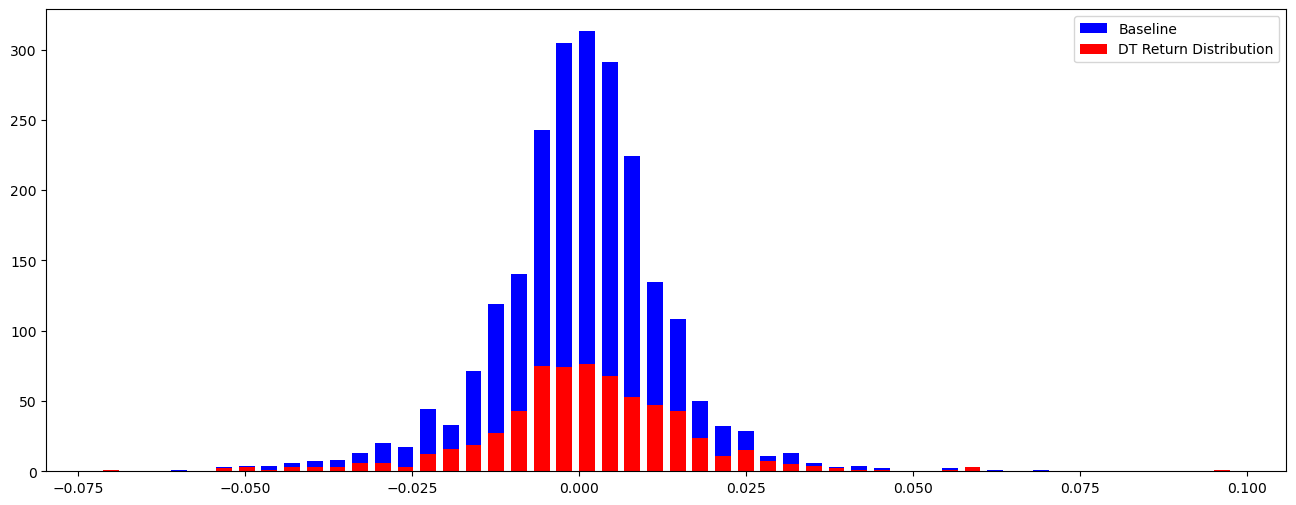

##### Summary of Decision Tree Returns ######
count    659.000000
mean       0.001043
std        0.015633
min       -0.071808
25%       -0.006514
50%        0.001074
75%        0.009661
max        0.097953
Name: DT, dtype: float64
########################################


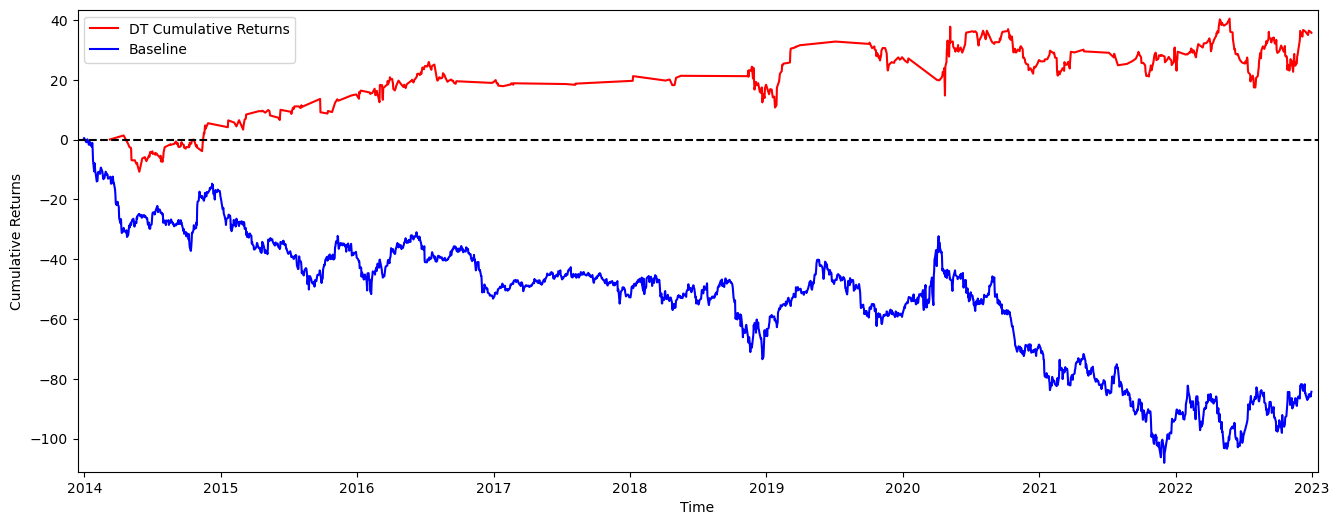

In [6]:
# importing the necessary libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance as yf
from numpy               import vstack, hstack
from sklearn             import tree

# downloading the data from yfinance API
start_date = '2013-01-01'
end_date = '2023-01-01'
V = yf.download("V", start=start_date, end=end_date)
V = V.drop('Volume',axis=1)
MA = yf.download("MA", start=start_date, end=end_date)
MA = MA.drop('Volume',axis=1)

def generate_lagged_atr(df: pd.DataFrame, n: int) -> pd.Series:
    """
    Generate a lagged technical indicator called Average True Range (ATR) for a given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame for which to generate the ATR indicator.
        n (int): The number of periods to use for the calculation.

    Returns:
        pd.Series: A Series containing the ATR indicator values.

    """
    # Reset index of DataFrame to start from 0
    df = df.reset_index()

    # Initialize variables
    index = 0
    true_range_list = [0]

    # Calculate True Range for each row of the DataFrame
    while index < df.index[-1]:
        true_range = (
            max(df.loc[index + 1, 'High'], df.loc[index, 'Close']) - 
            min(df.loc[index + 1, 'Low'], df.loc[index, 'Close'])
        )
        true_range_list.append(true_range)
        index += 1

    # Calculate the Exponential Moving Average of the True Range values
    atr_values = pd.Series(true_range_list).ewm(span=n, min_periods=n).mean()

    return atr_values

def generate_pairs_trading_variables(V, MA):
    """
    This function generates pairs trading variables by calculating the returns
    for two stocks V and MA and selecting the stock with the lowest return as the 
    target stock. It then uses the target stock to determine the open and close
    prices, as well as the returns for the pair.
    
    Parameters:
    V (pd.DataFrame): Historical data for stock V
    MA (pd.DataFrame): Historical data for stock MA
    
    Returns:
    variables (pd.DataFrame): A DataFrame containing the pairs trading variables
    """
    # Calculate returns for both stocks
    variables = pd.DataFrame({
        'V_returns': (V['Close'] / V['Close'].shift(7) - 1).shift(1),
        'MA_returns': (MA['Close'] / MA['Close'].shift(6) - 1).shift(1)
    })

    # Select the stock with the lowest return as the target stock
    variables['Target'] = variables.min(axis=1)
    
    # Determine which stock is the target stock
    variables['Is_V'] = variables['Target'].isin(variables['V_returns'])
    
    # Determine open and close prices based on target stock
    variables['Open'] = np.where(variables['Is_V'], V['Open'], MA['Open'])
    variables['Close'] = np.where(variables['Is_V'], V['Close'], MA['Close'])
    
    # Calculate returns for the pair
    variables['Returns'] = variables['Close'] / variables['Open'] - 1
    
    # Add original open prices for both stocks
    variables['V_open'] = V['Open']
    variables['MA_open'] = MA['Open']
    
    # Reset index and drop date column
    variables = variables.reset_index().drop('Date', axis=1)
    
    # Add lagged Average True Range as a variable
    variables['lagged_average_true_range'] = generate_lagged_atr(V, 40)
    
    # Drop any rows with missing values
    variables = variables.dropna()
    
    # Reset index and drop old index
    variables = variables.reset_index().drop('index', axis=1)
    
    return variables

# Following modeling is done based on a few selected features
# But, I believe further careful addition of features will significantly improve the signal to noise ratio

# Generate pairs trading variables from the dataframes V and MA
variables = generate_pairs_trading_variables(V, MA)

# Select the features that we will use to train the model
features = ['Is_V', 'MA_open', 'lagged_average_true_range', 'V_open']

# Define the number of days for training and testing, as well as a random seed
training_days = 189
testing_days = 63
random_seed = 8990

# Create an empty list to store the returns
returns = []

# Rolling calibration and testing of the Decision Tree Regressors
for ii in range(0, len(variables)-(training_days+testing_days), testing_days):
    X, y = [], []

    # Define the index for the end of the training and testing periods
    training_index = ii + training_days
    testing_index = ii + training_days + testing_days

    # Train the model using the last 189 days of data
    for i in range(ii, training_index):
        X.append([variables.iloc[i][var] for var in features])
        y.append(variables.iloc[i].Close)

    # Define the Decision Tree Regressor with hyperparameters
    model = tree.DecisionTreeRegressor(
        max_depth=20,
        min_samples_leaf=5,
        min_samples_split=15,
        random_state=random_seed
    )

    # Train the model using the selected features
    model.fit(vstack(X), hstack(y))

    XX = []

    # Test the model out-of-sample using the next 63 days
    for i in range(training_index, testing_index):
        XX.append([variables.iloc[i][var] for var in features])

    # Generate trades if the predicted close price is higher than the open price
    trades = np.where(
        model.predict(vstack(XX)) > variables['Open'][training_index:testing_index],
        variables['Returns'][training_index:testing_index],
        np.nan
    )

    # Append the trades to the returns list
    for value in trades:
        returns.append(value)
        
# Creating a comparison dataframe
ComparisonResults = pd.DataFrame({'Baseline': variables[-len(returns):].set_index(V[-len(returns):].index)['Returns'],
                                  'DT': returns})

# Summary statistics of Baseline
print("##### Summary of Baseline Returns ######")
print(ComparisonResults['Baseline'].describe())
print("########################################")

# Visualizing the distribution of Baseline and DT
fig, ax = plt.subplots(figsize=(16,6))
hist1, bins1 = np.histogram(ComparisonResults['Baseline'].dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2
ax.bar(center, hist1, align='center', width=width, label='Baseline', color = "blue")
hist2, bins2 = np.histogram(ComparisonResults['DT'].dropna(), bins=50)
ax.bar(center, hist2, align='center', width=width, label='DT Return Distribution', color = "red")
plt.legend()
plt.show()

# Summary statistics of DT
print("##### Summary of Decision Tree Returns ######")
print(ComparisonResults['DT'].describe())
print("########################################")

# Adding transaction costs to the return series and plotting the cumulative returns
transaction_cost = -0.0005 # 0.05% transaction cost

plt.figure(figsize=(16,6))
plt.plot(((ComparisonResults['DT'].dropna()+transaction_cost).cumsum())*100, color = 'red', label='DT Cumulative Returns')
plt.plot(((ComparisonResults['Baseline']+transaction_cost).cumsum())*100, color = "blue", label='Baseline')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()